# EVAC Examination

## Data Exploration

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [163]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [164]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


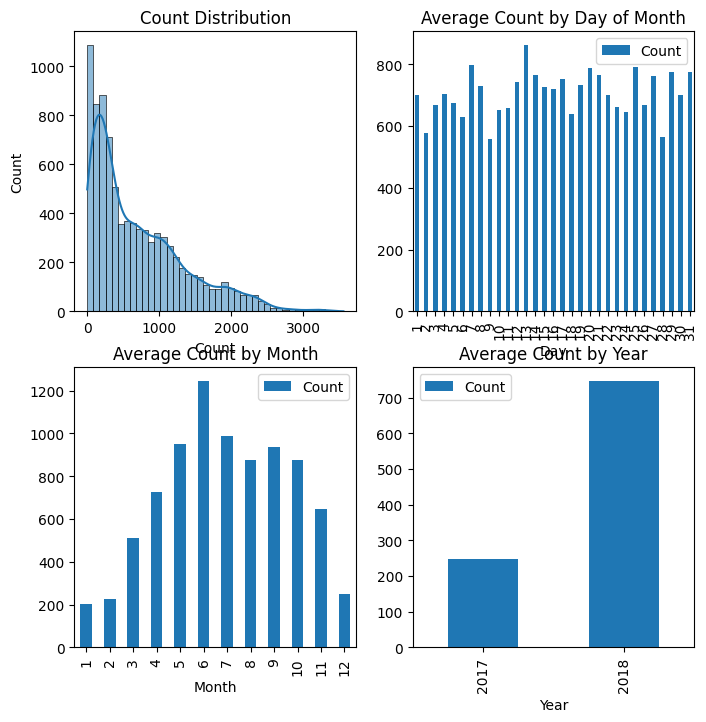

In [165]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [166]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [167]:
!pip install deap

In [168]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [169]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [170]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [171]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [172]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [173]:
import numpy
# randomise data
data = data.sample(frac=1).reset_index(drop=True)
data = data[:500]
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [174]:
def eval(individual, myNet):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(data)):
    input = [data['Temp'][i], data['Windspeed'][i], data['Visibility'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i], data['Hour'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000000000,
    fitness += abs(output[0] - data['Count'][i])
  return fitness,


In [175]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.5)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet)
print(baseline)

(1000000000000000,)


In [176]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [177]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet))

[0.17789061836586506, -0.7583644843636852, 0.9712748354360103, 0.3914523271102397, 0.43911077625329353, 0.18827061615858742, 0.7349955684732528, 0.7572218088156208, 0.29415520158090147, 0.31469685275521964, 0.12407815231906172, 0.3213855928792335, -0.9691906379782296, -0.24590286116104543, -0.7462627104312469, 0.5081089441657467, 0.07160778282826952, -0.23898104679667864, 0.2486590975033125, 0.8873674018498834, -0.014218722511311288, 0.41234827605648805, -0.5443895251479469, -0.6375825077548194, -0.14300044434914572, -0.12903644756409727, 0.3317677245913564, -0.022713329713109243, -0.6628010231805808, -0.25655747786363636, 0.8304203226396059, -0.328316089246139, -0.9560004329900076, -0.7016503834519847, -0.0926287522181608, 0.13897807582299948, -0.9382143282560336, 0.07782163087014138, -0.7896078230178478, -0.4973218167396516, 0.35146769438836833, 0.357378680600549, 0.5248635400653208, -0.5025668204734328, 0.6743917663885017, 0.4929464373204664, 0.15682949820678704, 0.7808122670897222,

In [178]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [179]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [180]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [181]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg    	gen	max  	min        	std        
4.4e+14	0  	1e+15	231010     	4.96387e+14
2.8e+14	1  	1e+15	234200     	4.48999e+14
3e+14  	2  	1e+15	239235     	4.58258e+14
3.8e+14	3  	1e+15	227439     	4.85386e+14
3.8e+14	4  	1e+15	267872     	4.85386e+14
2.6e+14	5  	1e+15	249631     	4.38634e+14
2.3e+14	6  	1e+15	228236     	4.20833e+14
2.8e+14	7  	1e+15	218847     	4.48999e+14
2.9e+14	8  	1e+15	240981     	4.53762e+14
2e+14  	9  	1e+15	248705     	4e+14      
2.5e+14	10 	1e+15	239480     	4.33013e+14
3.2e+14	11 	1e+15	352254     	4.66476e+14
2.6e+14	12 	1e+15	247066     	4.38634e+14
3e+14  	13 	1e+15	286256     	4.58258e+14
2.3e+14	14 	1e+15	232437     	4.20833e+14
3.1e+14	15 	1e+15	211460     	4.62493e+14
3.2e+14	16 	1e+15	255178     	4.66476e+14
3.6e+14	17 	1e+15	231535     	4.8e+14    
3.1e+14	18 	1e+15	340520     	4.62493e+14
3.4e+14	19 	1e+15	231585     	4.73709e+14
2.5e+14	20 	1e+15	282982     	4.33013e+14
2.2e+14	21 	1e+15	216922     	4.14246e+14
2.7e+14	22 	1e+15	259178     	4.43

[2.4189672823945965, -1.737592220871501, -1.7426825362058564, 1.573248989626453, 5.668359869054066, 2.1472601905157442, 6.668935529062705, 2.937341151760267, -6.463582454469093, -1.4926428180253097, 4.89729301862751, 5.1340393230398345, 3.9511001828622287, 4.6549582697904714, -5.437998511213414, 7.8900798502307765, 6.314110603896227, 2.1956464091823924, -3.645028506881909, -0.24339240397732687, -0.7195606915834031, -1.9058177751350902, 8.84808798753242, -4.452493208157437, -3.970846564108818, -0.013283332563443606, 2.4013029286733953, 3.295105351455484, 5.253674269089769, 5.00866091247922, -8.44202664567015, 3.554312009526372, -7.001912255816433, 5.5246731519692505, -6.103913484706545, -4.201013471243283, -11.523503028924521, 4.026279319088441, -1.5829755578031586, 1.0868643920432741, 4.013869106511037, -8.247415305082272, -0.6757778761701942, 1.6433571332480852, -0.7409776707816838, -6.6356301261973485, 0.6345167527738041, 9.201820536885247, 8.455888955552899, -1.4043439554021107, -3.

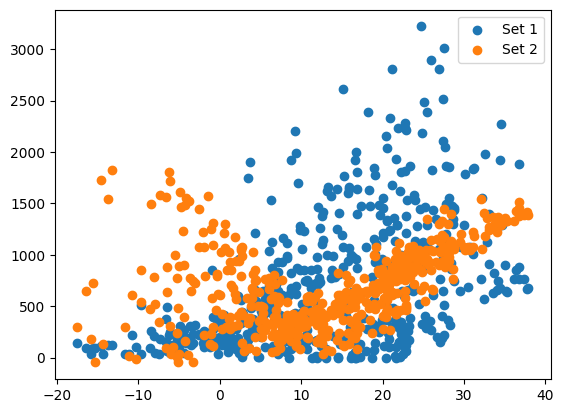

In [182]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet))
myNet.setWeightsLinear(best_ind)
print(toolbox.evaluate(best_ind, myNet))

inputs = [[data['Hour'][i],data['Temp'][i], data['Windspeed'][i], data['HireAvailable'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i]] for i in range(len(data))]
# Assuming you have two sets of data:
x_values1 = data['Temp'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1353.8749995]), array([906.62863571]), array([575.17243906]), array([492.54371011]), array([703.5382415]), array([38.40531707]), array([908.58671724]), array([501.80688627]), array([944.20155143]), array([142.25831315]), array([557.9089076]), array([494.55529416]), array([658.99440808]), array([1161.72213413]), array([816.57154221]), array([261.20849646]), array([945.60439207]), array([341.95927911]), array([614.72291478]), array([517.80909327]), array([221.02458446]), array([122.2885239]), array([900.84277995]), array([157.04347726]), array([66.36690567]), array([484.08145352]), array([275.84470536]), array([299.77215947]), array([721.991979]), array([1090.80162732]), array([341.15248032]), array([136.26240612]), array([854.73650061]), array([1248.88043253]), array([1057.14937256]), array([292.6664691]), array([663.71020843]), array([1447.44123617]), array([387.53911275]), array([536.74110727]), array([1304.09185701]), array([680.32078054]), array([978.47429517]), array([1393.

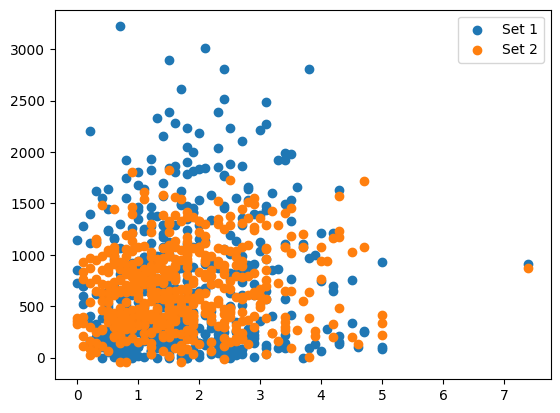

In [183]:
# Assuming you have two sets of data:
x_values1 = data['Windspeed'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1353.8749995]), array([906.62863571]), array([575.17243906]), array([492.54371011]), array([703.5382415]), array([38.40531707]), array([908.58671724]), array([501.80688627]), array([944.20155143]), array([142.25831315]), array([557.9089076]), array([494.55529416]), array([658.99440808]), array([1161.72213413]), array([816.57154221]), array([261.20849646]), array([945.60439207]), array([341.95927911]), array([614.72291478]), array([517.80909327]), array([221.02458446]), array([122.2885239]), array([900.84277995]), array([157.04347726]), array([66.36690567]), array([484.08145352]), array([275.84470536]), array([299.77215947]), array([721.991979]), array([1090.80162732]), array([341.15248032]), array([136.26240612]), array([854.73650061]), array([1248.88043253]), array([1057.14937256]), array([292.6664691]), array([663.71020843]), array([1447.44123617]), array([387.53911275]), array([536.74110727]), array([1304.09185701]), array([680.32078054]), array([978.47429517]), array([1393.

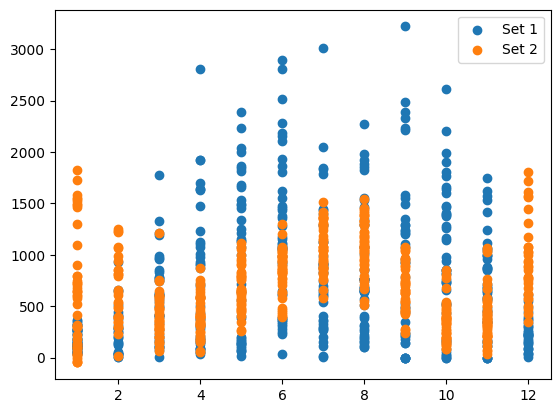

In [184]:
# Assuming you have two sets of data:
x_values1 = data['Month'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()